In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

In [3]:
D = pd.read_hdf('//FS2.smpp.local\RTO\CIS-PD MUSC\decoded_forms\\form509.h5')

In [61]:
sum(D.Q03=='Left')/len(D)

0.6700507614213198

In [5]:
taskList = np.array(['Standing', 'Walking', 'Walking while counting', 'Finger to nose--right hand', 
                     'Finger to nose--left hand', 'Alternating right hand movements', 
                     'Alternating left hand movements', 'Sit to stand', 'Drawing on a paper', 
                     'Typing on a computer keyboard', 'Assembling nuts and bolts', 
                     'Taking a glass of water and drinking', 'Organizing sheets in a folder', 'Folding towels', 
                     'Sitting'])
taskList_Abb = np.array(['Stndg', 'Wlkg', 'WlkgCnt', 'FtnR', 'FtnL', 'RamR', 'RamL', 'SitStand', 
                         'Drwg', 'Typg', 'NtsBts', 'Drnkg', 'Sheets', 'Fldg', 'Sitng'])

In [6]:
Questions = pd.read_sas('//FS2.smpp.local\RTO\CIS-PD MUSC\datadictionary.sas7bdat')
Questions = Questions[Questions.zFormID == 509.0]
Questions = Questions.drop(columns = list(set(Questions.columns)-set(['zFieldNm','zFieldNb'])))
Questions.zFieldNm = Questions.zFieldNm.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
Questions.zFieldNb = Questions.zFieldNb.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
## Correct Typos
Questions.loc[Questions.zFieldNm=='Walking  tremor left upper limb rating','zFieldNm'] = 'Walking tremor left upper limb rating'
Questions.loc[Questions.zFieldNb=='Q70','zFieldNm'] = 'Alternating left hand movements tremor right upper limb rating'
Questions.loc[Questions.zFieldNb=='Q145','zFieldNm'] = 'Sitting tremor right upper limb rating'

In [57]:
AllScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    try:
        side = side.lower()
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    RowScores = pd.DataFrame(columns=taskList_Abb, index=[ind])
    for task, task_abr in zip(taskList,taskList_Abb):
        QInd = Questions.zFieldNm==task+' tremor '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
#         print(task+' tremor '+side+' upper limb rating',row[QNum].values)
        RowScores[task_abr] = row[QNum].values[0]
    AllScores = pd.concat((AllScores,RowScores))
    

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


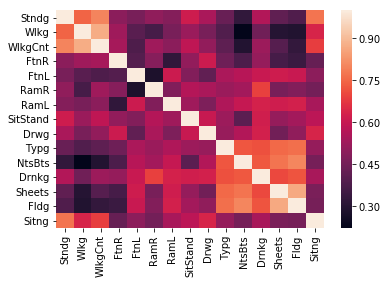

In [71]:
sns.heatmap(AllScores.corr())

In [30]:
D.shape

(197, 151)

In [58]:
AllScoresRMSE = pd.DataFrame(columns=taskList_Abb, index =taskList_Abb)
for x,y in itertools.product(taskList_Abb,taskList_Abb):
    AllScoresRMSE.loc[x,y] = ((AllScores[x]-AllScores[y])**2).mean()**.5

In [59]:
AllScoresRMSE = AllScoresRMSE[AllScoresRMSE.columns].astype(float)

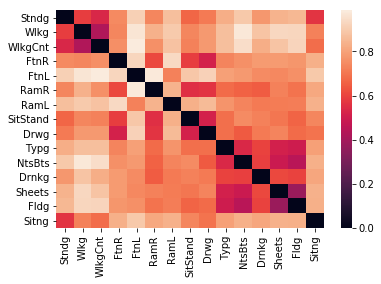

In [60]:
sns.heatmap(AllScoresRMSE)

In [7]:
BilatScores = pd.DataFrame()

In [21]:
BilatScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    try:
        side = side.lower()
        otherside = (set(['left','right'])-set([side]))
        otherside = [x for x in otherside][0]
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    for task, task_abr in zip(taskList,taskList_Abb):
        newind = len(BilatScores.index)
        RowScores = pd.DataFrame(columns=['ipsi', 'contra'], index=[ind])
        QInd = Questions.zFieldNm==task+' tremor '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
        RowScores['ipsi'] = row[QNum].values[0]
        QInd = Questions.zFieldNm==task+' tremor '+otherside+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
        RowScores['contra'] = row[QNum].values[0]
        
        BilatScores = pd.concat((BilatScores,RowScores))

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


In [10]:
BilatScores.corr()

,left,right
left,1.000000,0.342239
right,0.342239,1.000000


In [22]:
BilatScores.corr()

,ipsi,contra
ipsi,1.000000,0.407596
contra,0.407596,1.000000


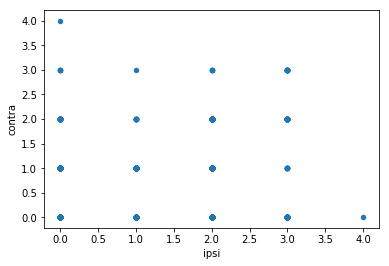

In [25]:
BilatScores.plot(x='ipsi',y='contra',kind = 'scatter')

In [53]:
BilatScoreCounts = pd.DataFrame(columns=[0, 1, 2, 3, 4], index = [0, 1, 2, 3, 4])
for x,y in itertools.product([0,1,2,3,4],[0,1,2,3,4]):
    BilatScoreCounts.loc[x,y] = sum((BilatScores.ipsi==x)&(BilatScores.contra==y))/sum(BilatScores.ipsi==x)

In [54]:
BilatScoreCounts = BilatScoreCounts[BilatScoreCounts.columns].astype(float)

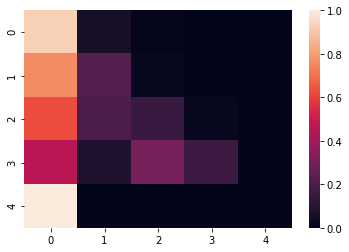

In [55]:
sns.heatmap(BilatScoreCounts)

In [31]:
(BilatScores.ipsi - BilatScores.contra).values

array([1., 0., 0., ..., 0., 0., 0.])

In [34]:
np.nanmean((BilatScores.ipsi - BilatScores.contra).values)

0.22524132999642474